In [1]:
import numpy as np
import pandas as pd
#import scipy.stats as stats
import json
import seaborn as sns
import qwikidata
import random
import matplotlib.pyplot as plt
from qwikidata.json_dump import WikidataJsonDump
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.sparql import (get_subclasses_of_item,
                              return_sparql_query_results)
from collections import Counter
from qwikidata.linked_data_interface import LdiResponseNotOk
from qwikidata.entity import WikidataItem, WikidataProperty, WikidataLexeme
import sqlite3
from urllib3.exceptions import MaxRetryError
import threading
import time
import timeit
import traceback
import plotly.graph_objects as go
import tldextract
from urllib.parse import urlparse
import ssl
import languages_and_countries
import importlib

In [2]:
#from notify_run import Notify
#notifier = Notify()
#notifier.register()

In [3]:
sql_db = sqlite3.connect('/media/k2031554/Samsung_T5/wikidata.db')
#sql_db = sqlite3.connect('F:/wikidata.db')

sql_cursor = sql_db.cursor()
#sql_cursor2 = sql_db.cursor()

def kill(conn):
    while True: 
        with open('iskill.txt','r') as f:
            time.sleep(1)
            if f.readline().strip() == 'yes':
                print('killed')
                conn.interrupt()
                
th = threading.Thread(target=kill,args=[sql_db])
th.start()

In [4]:
update = False

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

In [5]:
def get_entity(item_id):
    while True:
        try:
            entity = get_entity_dict_from_api(item_id)
            return entity
        except ConnectionError:
            #traceback.print_exc()
            continue
        except MaxRetryError:
            #traceback.print_exc()
            time.sleep(1)
        except LdiResponseNotOk:
            #traceback.print_exc()
            return 'deleted'

def get_label(item):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        labels = entity['labels']
    elif type(item) == dict:
        labels = item['labels']
    languages = ['en','fr','es','pt','pt-br','it','de']
    for l in languages:
        if l in labels:
            return labels[l]['value']
    return 'no-label'

def get_datatype(item):
    try:
        if type(item) == str:
            entity = get_entity(item)
            if entity == 'deleted':
                return entity
            datatype = entity['datatype']
        elif type(item) == dict:
            datatype = item['datatype']
        return datatype
    except KeyError:
        return 'none'

def get_claim_values_of(item, property_id):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        claims = entity['claims']
    elif type(item) == dict:
        claims = item['claims']
    if property_id in claims:
        instance_of_claims = claims[property_id]
        return [i['mainsnak']['datavalue']['value']['id'] for i in instance_of_claims]
    else:
        return []
    
def aggregate_other(df, by, count_name='count', other_thr=1):
    df_c = df.copy()
    df_c = df_c[[by,count_name]]
    total_count = df_c[count_name].sum()
    df_c['per'] = df_c[count_name].apply(lambda x: 100*x/total_count)

    other_df_c = df_c[df_c['per'] < other_thr].sum()
    other_df_c[by] = 'other'

    df_c = df_c.append(
        other_df_c, ignore_index=True
    ).sort_values('per',ascending=False).reset_index(drop=True)
    df_c = df_c[df_c['per'] >= other_thr]

    return df_c

# Head 10

In [6]:
sql_cursor.execute(
    ''' select * from refs limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['entity_id','claim_id','claim_rank','property_id','reference_block_hash','reference_property_id',
                  'reference_index','reference_snaktype','reference_datatype','reference_value']
head_10

entity_id                                 claim_id claim_rank property_id  \
0        Q8  Q8$475e48c8-41fa-5739-e46e-27ff20507977     normal       P1245   
1        Q8  q8$0FC7FB9A-B5CA-4762-98AE-1B0BDC1EEF39     normal        P373   
2        Q8  q8$E2EFA381-BA5D-4F52-AF74-660B9A044C1E     normal         P31   
3        Q8  q8$5DB9C22E-4D86-4FB1-AC36-5C75CC806D6A     normal         P31   
4        Q8  q8$522798CD-60CD-4EAE-BE3B-365EFD24F2EC     normal        P508   
5        Q8  q8$7dcd6734-4ece-8b37-9386-92e5d4e801cd     normal         P18   
6        Q8  Q8$E805258B-7B18-4558-980E-425F5713DF51     normal        P910   
7        Q8  Q8$A6CF669F-6DD6-49A3-B084-6A31B119A535     normal        P349   
8        Q8  Q8$63214A9F-B2C8-42F9-8DA0-B046A989DDCF     normal        P646   
9        Q8  Q8$63214A9F-B2C8-42F9-8DA0-B046A989DDCF     normal        P646   

                       reference_block_hash reference_property_id  \
0                                      none                  none   
1                                      none                  none   
2                                      none                  none   
3                                      none                  none   
4  a235ba3d92daf43853b23688674b7ab464b4eea8                  P248   
5                                      none                  none   
6                                      none                  none   
7                                      none                  none   
8  2b00cb481cddcac7623114367489b5c194901c4a                  P248   
9  2b00cb481cddcac7623114367489b5c194901c4a                  P577   

  reference_index reference_snaktype reference_datatype  \
0            none               none               none   
1            none               none               none   
2            none               none               none   
3            none               none               none   
4               0              value      wikibase-item   
5            none               none               none   
6            none               none               none   
7            none               none               none   
8               0              value      wikibase-item   
9               0              value               time   

                                     reference_value  
0                                               none  
1                                               none  
2                                               none  
3                                               none  
4  {'entity-type': 'item', 'numeric-id': 460907, ...  
5                                               none  
6                                               none  
7                                               none  
8  {'entity-type': 'item', 'numeric-id': 15241312...  
9  {'time': '+2013-10-28T00:00:00Z', 'timezone': ...

## Total count of claims and references

In [7]:
if update:
    sql_cursor.execute(
        ''' select count(*) from refs
     '''
    )
    total_count_entries = sql_cursor.fetchall()[0][0]
else:
    total_count_entries = 468069905
print('There are {} total entries'.format(total_count_entries))

There are 468069905 total entries


In [8]:
if update:
    sql_cursor.execute(
        ''' select count(distinct claim_id) from refs
     '''
    )
    total_count_claims = sql_cursor.fetchall()[0][0]
else:
    total_count_claims = 190748309
print('There are {} total claims nodes'.format(total_count_claims))

There are 190748309 total claims nodes


There are 44830071 total claims with no references
There are 145918238 total claims with references


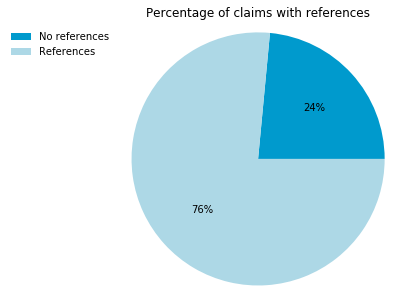

In [9]:
if update:
    sql_cursor.execute(
        ''' select count(*) from refs where reference_block_hash = 'none'
     '''
    )
    total_count_claims_no_refs = sql_cursor.fetchall()[0][0]
else:
    total_count_claims_no_refs = 44830071
total_count_claims_refs = total_count_claims - total_count_claims_no_refs
print('There are {} total claims with no references'.format(total_count_claims_no_refs))
print('There are {} total claims with references'.format(total_count_claims_refs))


fig, ax = plt.subplots(figsize=[5,5])
percentages = [total_count_claims_no_refs, total_count_claims_refs]

labels = ['No references','References']

ax.pie(percentages, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,labeldistance=None)
ax.axis('equal')
ax.set_title("Percentage of claims with references")
ax.legend(frameon=False, bbox_to_anchor=(0,1))
plt.show()

In [11]:
# Analyze number of distinct references
# See average number of references per claim
if update:
    sql_cursor.execute(
        ''' 
        SELECT COUNT(*) FROM (SELECT DISTINCT reference_block_hash FROM refs
        INDEXED BY reference_block_hash_index) AS temp;
     '''
    )
    total_count_refs = sql_cursor.fetchall()[0][0]
else:
    total_count_refs = 13108427
print('There are {} total references nodes'.format(total_count_refs))
print('For each unique reference node there are {} claims with references'.format(total_count_claims_refs/total_count_refs))

There are 13108427 total references nodes
For each unique reference node there are 11.131636007890192 claims with references


# Distribution of kinds of references

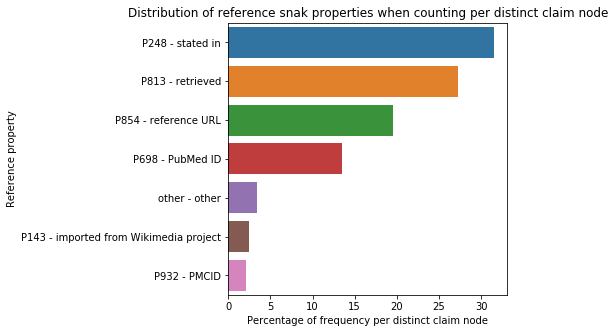

In [15]:
# One reference node may be connected to many statements. This aggregation is base on statements, meaning that
# if a reference node apears 100 times and has a Stated In property, this property is counted 100 times.
if update:
    sql_cursor.execute(
        ''' select reference_property_id, count(*) as c from refs group by reference_property_id order by c desc
     '''
    )
    reference_property_count = pd.DataFrame(sql_cursor.fetchall())
    reference_property_count.columns = ['reference_property_id','count']
    reference_property_count = reference_property_count[reference_property_count['reference_property_id'] != 'none'].reset_index(drop=True)
    reference_property_count['datatype'] = reference_property_count['reference_property_id'].transform(get_datatype)
    reference_property_count.to_csv('reference_property_count.csv',index=False)
else:
    reference_property_count = pd.read_csv('data/reference_property_count.csv')
    
other_thr = 1 #as in 1%

reference_property_count = reference_property_count[reference_property_count['reference_property_id'] != 'none'].reset_index(drop=True)
reference_property_count_c = reference_property_count.copy()
reference_property_count_c['per'] = reference_property_count_c['count'].apply(lambda x: 100*x/reference_property_count_c['count'].sum())

other_reference_property = reference_property_count_c[reference_property_count_c['per'] < other_thr].sum()
other_reference_property['reference_property_id'] = 'other'

reference_property_count_c = reference_property_count_c.append(other_reference_property, ignore_index=True).sort_values('per',ascending=False).reset_index(drop=True)
reference_property_count_c = reference_property_count_c[reference_property_count_c['per'] >= other_thr]
reference_property_count_c['label'] = reference_property_count_c['reference_property_id'].transform(lambda x : get_label(x) if x!= 'other' else x)


fig, ax = plt.subplots(figsize=[5,5])
percentages = reference_property_count_c['per']
labels = reference_property_count_c.apply(lambda x : ' - '.join([x['reference_property_id'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of reference snak properties when counting per distinct claim node")
ax.set(ylabel='Reference property', xlabel='Percentage of frequency per distinct claim node')
plt.show()

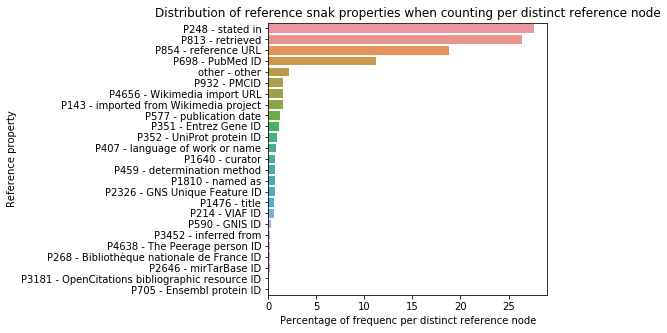

In [16]:
# This is the reference property counted per reference node, so that each reference snak appears only once.
if update:
    sql_cursor.execute(
        ''' select reference_property_id, count(*) as c from reference_nodes_values group by reference_property_id order by c desc
     '''
    )
    reference_property_count2 = pd.DataFrame(sql_cursor.fetchall())
    reference_property_count2.columns = ['reference_property_id','count']
    reference_property_count2 = reference_property_count2[reference_property_count2['reference_property_id'] != 'none'].reset_index(drop=True)
    reference_property_count2['datatype'] = reference_property_count2['reference_property_id'].transform(get_datatype)
    reference_property_count2.to_csv('reference_property_per_reference_node_count.csv',index=False)
else:
    reference_property_count2 = pd.read_csv('data/reference_property_per_reference_node_count.csv')
    
other_thr = 0.1 #as in 1%

reference_property_count2 = reference_property_count2[reference_property_count2['reference_property_id'] != 'none'].reset_index(drop=True)
reference_property_count_c2 = reference_property_count2.copy()
reference_property_count_c2['per'] = reference_property_count_c2['count'].apply(lambda x: 100*x/reference_property_count_c2['count'].sum())

other_reference_property2 = reference_property_count_c2[reference_property_count_c2['per'] < other_thr].sum()
other_reference_property2['reference_property_id'] = 'other'

reference_property_count_c2 = reference_property_count_c2.append(other_reference_property2, ignore_index=True).sort_values('per',ascending=False).reset_index(drop=True)
reference_property_count_c2 = reference_property_count_c2[reference_property_count_c2['per'] >= other_thr]
reference_property_count_c2['label'] = reference_property_count_c2['reference_property_id'].transform(lambda x : get_label(x) if x!= 'other' else x)


fig, ax = plt.subplots(figsize=[5,5])
percentages = reference_property_count_c2['per']
labels = reference_property_count_c2.apply(lambda x : ' - '.join([x['reference_property_id'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of reference snak properties when counting per distinct reference node")
ax.set(ylabel='Reference property', xlabel='Percentage of frequenc per distinct reference node')
plt.show()

  reference_snaktype      count
0            novalue        192
1          somevalue         18
2              value  423239624


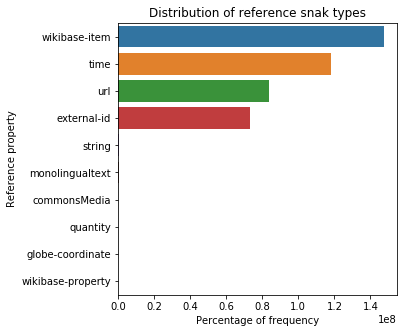

In [17]:
# Aggregate and show results 
if update:
    sql_cursor.execute(
        ''' select reference_snaktype, reference_datatype, count(*) as c
        from refs group by reference_snaktype, reference_datatype
        order by c desc
     '''
    )
    reference_snaktype_datatype_count = pd.DataFrame(sql_cursor.fetchall())
    reference_snaktype_datatype_count.columns = ['reference_snaktype','reference_datatype','count']
    reference_snaktype_datatype_count.to_csv('snaktype_and_datatype_count.csv',index=False)
else:
    reference_snaktype_datatype_count = pd.read_csv('data/snaktype_and_datatype_count.csv')

reference_snaktype_datatype_count = reference_snaktype_datatype_count[reference_snaktype_datatype_count['reference_snaktype'] != 'none'].reset_index(drop=True)
group_by_snaktype = reference_snaktype_datatype_count.groupby('reference_snaktype').sum().reset_index()
print(group_by_snaktype)

reference_snaktype_datatype_count_value = reference_snaktype_datatype_count[reference_snaktype_datatype_count['reference_snaktype'] == 'value']

fig, ax = plt.subplots(figsize=[5,5])
percentages = reference_snaktype_datatype_count_value['count']
labels = reference_snaktype_datatype_count_value['reference_datatype']

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of reference snak types")
ax.set(ylabel='Reference property', xlabel='Percentage of frequency')
plt.show()

# STATED-IN OBJECTS AND SOURCES: DISTRIBUTION OF INSTANCES AND CLASSES

In [18]:
if update:
    sql_cursor.execute(
        ''' select reference_value
        from reference_nodes_values 
        where reference_property_id = 'P248'
        and reference_snaktype = 'value'
     '''
    )
    stated_in_ids = pd.DataFrame(sql_cursor.fetchall())
    stated_in_ids[0] = stated_in_ids[0].transform(lambda x : json.loads(x.replace("'",'"'))['id'])
    stated_in_ids.columns = ['stated_in_id']
    stated_in_ids.to_csv('stated_in_entities.csv', index=False)
    stated_in_ids['count'] = 1
    stated_in_ids = stated_in_ids.groupby('stated_in_id').sum().sort_values('count',ascending=False).reset_index()
    
    stated_in_ids['label'] = 'none'
    stated_in_ids['instance_of'] = 'none'
    stated_in_ids['subclass_of'] = 'none'
    total = stated_in_ids.shape[0]
    for i in range(total):
        print('{}%'.format((i+1)/total*100) + ' '*15, end='\r')
        if 'none' in list(stated_in_ids.loc[i,['label','instance_of','subclass_of']]):
            entity = get_entity(stated_in_ids.loc[i,'stated_in_id'])
            stated_in_ids.loc[i,'label'] = str(get_label(entity))
            stated_in_ids.loc[i,'instance_of'] = ','.join(get_claim_values_of(entity,'P31'))
            stated_in_ids.loc[i,'subclass_of'] = ','.join(get_claim_values_of(entity,'P279'))
    stated_in_ids.to_csv('stated_in_entities_count.csv', index=False)
else:
    stated_in_ids = pd.read_csv('data/stated_in_entities_count.csv').fillna('')
stated_in_ids

stated_in_id    count  \
0         Q5412157  5392389   
1          Q229883  1966002   
2         Q5188229   890101   
3        Q20641742   456183   
4        Q28018111   313936   
...            ...      ...   
63011    Q28568343        1   
63012    Q28568346        1   
63013    Q28568351        1   
63014    Q28568358        1   
63015     Q9979220        1   

                                                   label  \
0                                  Europe PubMed Central   
1                                         PubMed Central   
2                                               Crossref   
3                                              NCBI Gene   
4                                            UniProt-GOA   
...                                                  ...   
63011  Increased O-GlcNAc levels during reperfusion l...   
63012  Effects of dietary Pi on the renal Na+-depende...   
63013  Voltage-dependent K+ channel beta subunits in ...   
63014  Subcellular localization of growth inhibitory ...   
63015                                           no-label   

                              instance_of subclass_of  
0                                Q7096323              
1      Q212805,Q1789476,Q1916557,Q7096323              
2                        Q163740,Q1789476              
3                                Q4117139              
4                                Q4117139              
...                                   ...         ...  
63011                           Q13442814              
63012                           Q13442814              
63013                           Q13442814              
63014                           Q13442814              
63015                              Q15416              

[63016 rows x 5 columns]

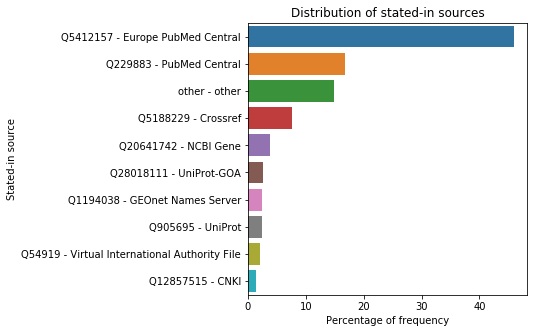

In [19]:
other_thr = 1 #as in 1%

stated_in_ids_c = stated_in_ids.copy()
stated_in_ids_c = stated_in_ids_c.drop(['subclass_of','instance_of'],axis=1)
total_count = stated_in_ids_c['count'].sum()
stated_in_ids_c['per'] = stated_in_ids_c['count'].apply(lambda x: 100*x/total_count)

other_stated_in_ids_c = stated_in_ids_c[stated_in_ids_c['per'] < other_thr].sum()
other_stated_in_ids_c['stated_in_id'] = 'other'
other_stated_in_ids_c['label'] = 'other'

stated_in_ids_c = stated_in_ids_c.append(other_stated_in_ids_c, ignore_index=True).sort_values('per',ascending=False).reset_index(drop=True)
stated_in_ids_c = stated_in_ids_c[stated_in_ids_c['per'] >= other_thr]

fig, ax = plt.subplots(figsize=[5,5])
percentages = stated_in_ids_c['per']
labels = stated_in_ids_c.apply(lambda x : ' - '.join([x['stated_in_id'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of stated-in sources")
ax.set(ylabel='Stated-in source', xlabel='Percentage of frequency')
plt.show()

In [21]:
if update:
    stated_in_ids_instance_of = stated_in_ids.copy()
    stated_in_ids_instance_of = stated_in_ids_instance_of.drop(['label','subclass_of'],axis=1)
    stated_in_ids_instance_of = (stated_in_ids_instance_of.set_index(['stated_in_id', 'count'])
       .apply(lambda x: x.str.split(',').explode())
       .reset_index())

    stated_in_ids_instance_of.drop('stated_in_id',axis=1,inplace=True)
    stated_in_ids_instance_of = stated_in_ids_instance_of[['instance_of','count']]
    stated_in_ids_instance_of = (stated_in_ids_instance_of.groupby('instance_of')
                                 .sum().sort_values('count',ascending=False).reset_index())
    stated_in_ids_instance_of['label'] = 'none'
    stated_in_ids_instance_of['instance_of_of'] = 'none'
    stated_in_ids_instance_of['subclass_of_of'] = 'none'

    total = stated_in_ids_instance_of.shape[0]
    for i in range(total):
        try:
            print('{}%'.format((i+1)/total*100) + ' '*15, end='\r')
            if 'none' == stated_in_ids_instance_of.loc[i,'label']:
                if stated_in_ids_instance_of.loc[i,'instance_of'] != '':
                    entity = get_entity(stated_in_ids_instance_of.loc[i,'instance_of'])
                    stated_in_ids_instance_of.loc[i,'label'] = str(get_label(entity))
                    stated_in_ids_instance_of.loc[i,'instance_of_of'] = ','.join(get_claim_values_of(entity,'P31'))
                    stated_in_ids_instance_of.loc[i,'subclass_of_of'] = ','.join(get_claim_values_of(entity,'P279'))
        except Exception as e:
            print(e,i)
            traceback.print_exc()
            raise
    stated_in_ids_instance_of.to_csv('stated_in_ids_instance_of.csv', index=False)
else:
    stated_in_ids_instance_of = pd.read_csv('data/stated_in_ids_instance_of.csv')
    stated_in_ids_instance_of = stated_in_ids_instance_of.fillna('')
stated_in_ids_instance_of

instance_of    count                   label instance_of_of  \
0       Q7096323  7374732  open-access repository                  
1       Q1789476  2889322  bibliographic database                  
2        Q212805  1995199         digital library      Q25397890   
3       Q1916557  1988388        medical database                  
4       Q4117139  1246438     biological database                  
...          ...      ...                     ...            ...   
1486     Q178790        1             trade union                  
1487    Q3889692        1        college of music                  
1488      Q38926        1                    news                  
1489     Q178651        1               interview                  
1490     Q998426        1             bookselling       Q1914636   

                  subclass_of_of  
0              Q1235234,Q7094076  
1              Q1865123,Q2352616  
2           Q7075,Q1497649,Q8513  
3                       Q1391125  
4                       Q1391125  
...                          ...  
1486                     Q681615  
1487             Q38723,Q1021290  
1488                      Q11024  
1489  Q3689704,Q15621286,Q483394  
1490                     Q126793  

[1491 rows x 5 columns]

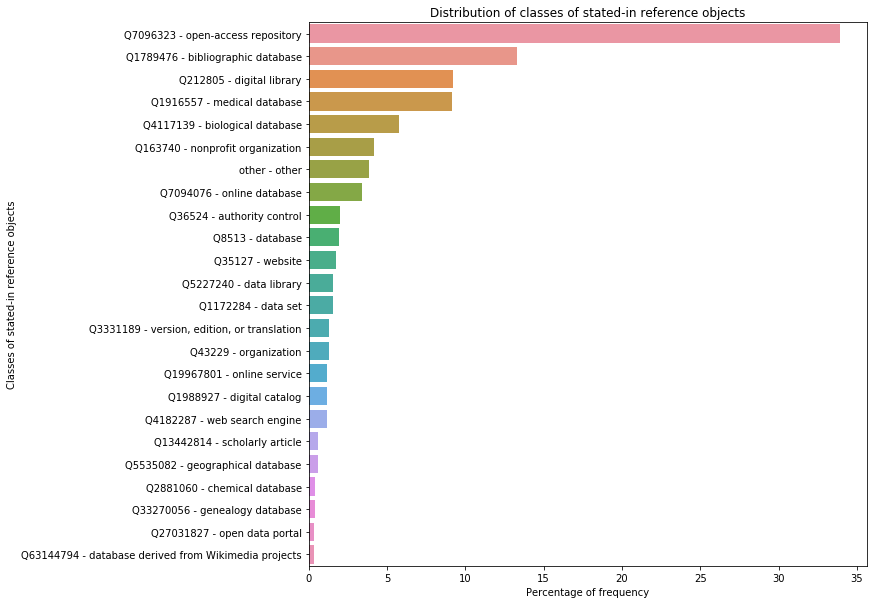

In [22]:
other_thr = 0.25 #as in 0.25%

stated_in_ids_instance_of_c = stated_in_ids_instance_of.copy()
stated_in_ids_instance_of_c = stated_in_ids_instance_of_c.drop(['instance_of_of','subclass_of_of'],axis=1)
total_count = stated_in_ids_instance_of_c['count'].sum()
stated_in_ids_instance_of_c['per'] = stated_in_ids_instance_of_c['count'].apply(lambda x: 100*x/total_count)

other_stated_in_ids_instance_of_c = stated_in_ids_instance_of_c[stated_in_ids_instance_of_c['per'] < other_thr].sum()
other_stated_in_ids_instance_of_c['instance_of'] = 'other'
other_stated_in_ids_instance_of_c['label'] = 'other'

stated_in_ids_instance_of_c = stated_in_ids_instance_of_c.append(
    other_stated_in_ids_instance_of_c, ignore_index=True
).sort_values('per',ascending=False).reset_index(drop=True)
stated_in_ids_instance_of_c = stated_in_ids_instance_of_c[stated_in_ids_instance_of_c['per'] >= other_thr]

fig, ax = plt.subplots(figsize=[10,10])
percentages = stated_in_ids_instance_of_c['per']
labels = stated_in_ids_instance_of_c.apply(lambda x : ' - '.join([x['instance_of'],x['label']]), axis=1)

ax = sns.barplot(y=labels, x=percentages)
ax.set_title("Distribution of classes of stated-in reference objects")
ax.set(ylabel='Classes of stated-in reference objects', xlabel='Percentage of frequency')
plt.show()

## Closer look and some examples

In [23]:
# In order of largest representation:
stated_in_examples_class, stated_in_examples_labels = [], []
for row in stated_in_ids_instance_of_c.itertuples():
    stated_in_examples_class.append(row.label + '({})'.format(row.instance_of))

    stated_in_Q = stated_in_ids[stated_in_ids['instance_of'].apply(lambda x : row.instance_of in x)]
    examples = list(stated_in_Q.apply(lambda x: x['label'] + '({})'.format(x['stated_in_id']), axis=1))

    if len(stated_in_Q) > 15:
        examples = random.sample(examples,15)
    stated_in_examples_labels.append(','.join(examples))
    
fig = go.Figure(data=[go.Table(
        header=dict(
            values=["Stated-in Class", "Instance Examples"],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[stated_in_examples_class, stated_in_examples_labels],
            align = "left")
    )
])

fig.update_layout(
    height=2900,
    showlegend=False,
    title_text="Examples of each stated-in class",
)

fig.show()

# REFERENCE URL: DOMAINS AND LANGUAGES

In [11]:
if update:
    sql_cursor.execute(
        ''' select reference_value
        from reference_nodes_values 
        where reference_property_id = 'P854'
        and reference_snaktype = 'value'
     '''
    )
    reference_urls = pd.DataFrame(sql_cursor.fetchall())
    reference_urls.columns = ['reference_url']
    reference_urls['count'] = 1
    reference_urls = reference_urls.groupby('reference_url').sum().sort_values('count',ascending=False).reset_index()
    
    domains_df = reference_urls['reference_url'].transform(tldextract.extract)
    domains_df = pd.DataFrame(domains_df.tolist(), index=domains_df.index)
    reference_urls[['subdomain','domain','suffix']] = domains_df
    
    urlparse_df = reference_urls['reference_url'].transform(urlparse)
    urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
    reference_urls[['scheme','netloc','path','params','query','fragment']] = urlparse_df
    
    reference_urls.to_csv('reference_urls.csv', index=False)
else:
    reference_urls = pd.read_csv('data/reference_urls.csv',low_memory=False).fillna('none')
reference_urls

reference_url  count subdomain  \
0        http://geonames.usgs.gov/docs/federalcodes/Nat...   6284  geonames   
1                 http://haroldcorwin.net/rc3/rc39b.csv.gz   2588      none   
2        http://www.pap.hacienda.gob.es/Invente/pagBusc...    457   www.pap   
3        https://administracionelectronica.gob.es/ctt/r...    412      none   
4        http://www.ebi.ac.uk/QuickGO/annotations?geneP...    270       www   
...                                                    ...    ...       ...   
6464604  https://api.crossref.org/works/10.1007%2FBF027...      1       api   
6464605  https://api.crossref.org/works/10.1007%2FBF027...      1       api   
6464606  https://api.crossref.org/works/10.1007%2FBF027...      1       api   
6464607  https://api.crossref.org/works/10.1007%2FBF027...      1       api   
6464608  https://เทศบาลตําบลบรบือ.com/th/pages/8949-%E0...      1      none   

                            domain  suffix scheme  \
0                             usgs     gov   http   
1                     haroldcorwin     net   http   
2                         hacienda  gob.es   http   
3        administracionelectronica  gob.es  https   
4                              ebi   ac.uk   http   
...                            ...     ...    ...   
6464604                   crossref     org  https   
6464605                   crossref     org  https   
6464606                   crossref     org  https   
6464607                   crossref     org  https   
6464608           เทศบาลตําบลบรบือ     com  https   

                                   netloc  \
0                       geonames.usgs.gov   
1                        haroldcorwin.net   
2                 www.pap.hacienda.gob.es   
3        administracionelectronica.gob.es   
4                           www.ebi.ac.uk   
...                                   ...   
6464604                  api.crossref.org   
6464605                  api.crossref.org   
6464606                  api.crossref.org   
6464607                  api.crossref.org   
6464608              เทศบาลตําบลบรบือ.com   

                                                      path params  \
0         /docs/federalcodes/NationalFedCodes_20160801.zip   none   
1                                        /rc3/rc39b.csv.gz   none   
2                           /Invente/pagBuscadorEntes.aspx   none   
3        /ctt/resources/Soluciones/238/Descargas/Listad...   none   
4                                     /QuickGO/annotations   none   
...                                                    ...    ...   
6464604                        /works/10.1007%2FBF02718167   none   
6464605                        /works/10.1007%2FBF02718159   none   
6464606                        /works/10.1007%2FBF02718158   none   
6464607                        /works/10.1007%2FBF02718147   none   
6464608  /th/pages/8949-%E0%B8%9B%E0%B8%A3%E0%B8%B0%E0%...   none   

                                  query fragment  
0                                  none     none  
1                                  none     none  
2                                  none     none  
3                                  none     none  
4        geneProductId=UniProtKB:P35222     none  
...                                 ...      ...  
6464604                            none     none  
6464605                            none     none  
6464606                            none     none  
6464607                            none     none  
6464608                            none     none  

[6464609 rows x 11 columns]

There are 42076 unique domains.


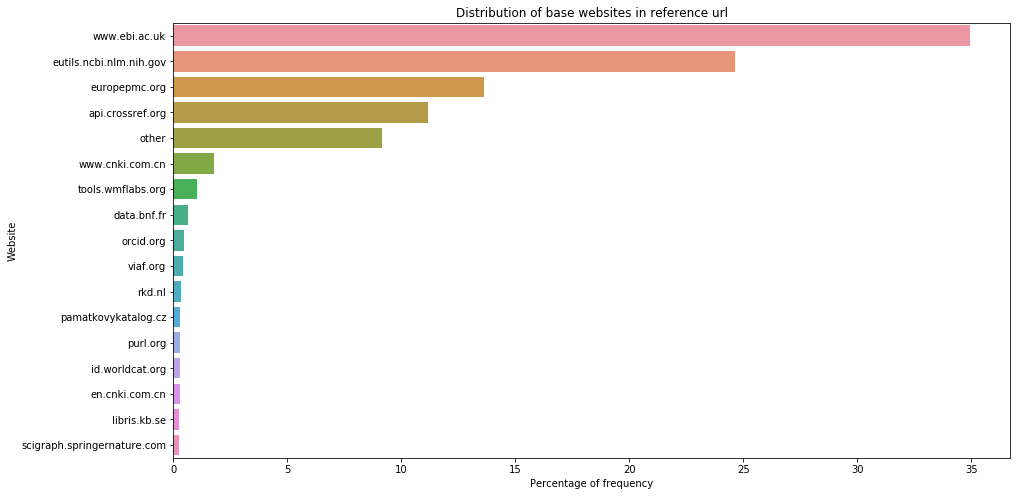

In [8]:
netlocs_df = reference_urls[['netloc','count']].groupby('netloc').sum().sort_values('count',ascending=False).reset_index()
netlocs_df_agg = aggregate_other(netlocs_df, by='netloc', other_thr=0.25)
print('There are {} unique domains.'.format(netlocs_df.shape[0]))

fig, ax = plt.subplots(figsize=[15,8])

ax = sns.barplot(y='netloc', x='per', data = netlocs_df_agg)
ax.set_title("Distribution of base websites in reference url")
ax.set(ylabel='Website', xlabel='Percentage of frequency')
plt.show()

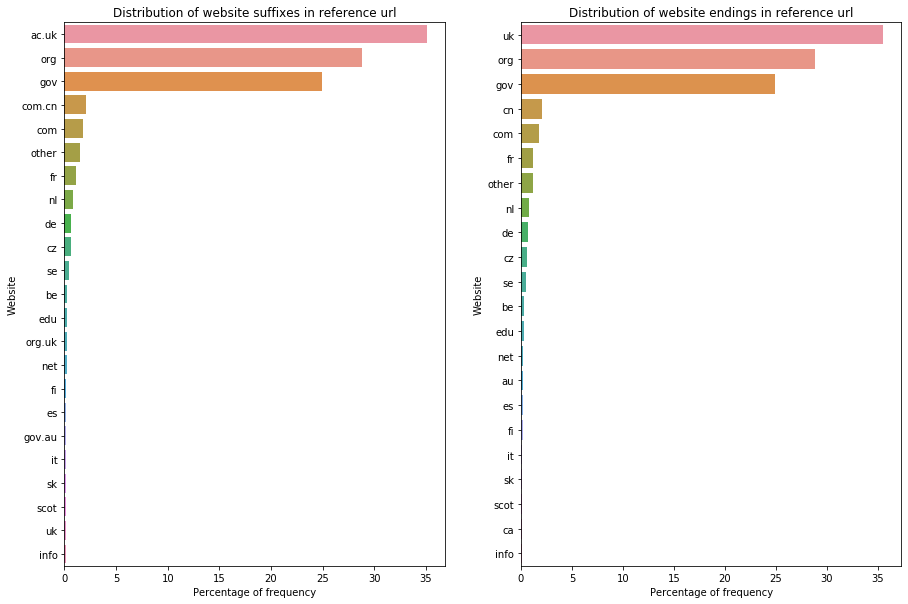

In [9]:
suffix_df = reference_urls[['suffix','count']].groupby('suffix').sum().sort_values('count',ascending=False).reset_index()
suffix_df['end'] = suffix_df['suffix'].transform(lambda x: x.split('.')[-1])
suffix_df_agg = aggregate_other(suffix_df, by='suffix', other_thr=0.1)

fig, ax = plt.subplots(1,2,figsize=[15,10])

g = sns.barplot(y='suffix', x='per', data = suffix_df_agg, ax=ax[0])
g.set_title("Distribution of website suffixes in reference url")
g.set(ylabel='Website', xlabel='Percentage of frequency')

suffix_end_df = suffix_df[['end','count']].groupby('end').sum().sort_values('count',ascending=False).reset_index()
suffix_end_df_agg = aggregate_other(suffix_end_df, by='end', other_thr=0.1)
g = sns.barplot(y='end', x='per', data = suffix_end_df_agg, ax=ax[1])
g.set_title("Distribution of website endings in reference url")
g.set(ylabel='Website', xlabel='Percentage of frequency')
plt.show()

In [17]:
from bs4 import BeautifulSoup
import requests
from urllib import parse
from langdetect import detect
from requests.exceptions import ReadTimeout, TooManyRedirects, ConnectionError, ConnectTimeout,\
    InvalidSchema, InvalidURL
from langdetect.lang_detect_exception import LangDetectException
from urllib3.exceptions import ProtocolError
import urllib.request
import socket
import langid
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


def get_url_language(html):
    try:
        #with urllib.request.urlopen(url) as response:
        #    html = response.read()
        soup = BeautifulSoup(html, "lxml")
        [s.decompose() for s in soup("script")]  # remove <script> elements
        if soup.body == None:
            return 'no body'
        body_text = soup.body.get_text()
        return langid.classify(body_text)
        #return detect(body_text)
    except:
        raise
        return 'error'

def get_access_attrs(r, timeout=(10,60*2), as_dict=True):
    chunked_error_retries = 5
    with requests.Session() as s:
        try:
            #resp = urllib.request.urlopen(r, context=context, timeout=timeout)
            headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
            resp = s.get(url=r, timeout=timeout, stream=True, verify=False, headers=headers)
            error_msg = 'none'
        except (TooManyRedirects) as e:
            resp = e.response
            error_msg = str(e)
        except (ReadTimeout, ConnectTimeout) as e:
            resp = requests.models.Response()
            resp.reason = 'timeout'
            resp.status_code = 408
            error_msg = str(e)
        except (ConnectionError) as e:
            #print(r)
            #traceback.print_exc()
            resp = requests.models.Response()
            resp.reason = 'connection error'
            resp.status_code = 500
            error_msg = str(e)
        except InvalidSchema as e:
            try:
                resp = requests.models.Response()
                with urllib.request.urlopen(r, timeout=timeout[1]) as resp_urllib:
                    resp.headers = resp_urllib.headers
                    resp.url = resp_urllib.url
                    error_msg = str(e)
                    resp.status_code = resp_urllib.code if hasattr(resp_urllib,'code') else None
                    resp.reason = resp_urllib.reason if hasattr(resp_urllib,'reason') else None
            except urllib.error.URLError as e:
                resp = requests.models.Response()
                resp.reason = 'malformed or invalid url'
                resp.status_code = 400
                error_msg = str(e)
        except (UnicodeError, InvalidURL) as e:
            resp = requests.models.Response()
            resp.reason = 'malformed or invalid url'
            resp.status_code = 400
            error_msg = str(e)
        except (Exception, KeyboardInterrupt) as e:
            print(r,e)
            traceback.print_exc()
            raise
        while True:
            try:
                attrs = {
                    'url': r,
                    'error_msg': error_msg,
                    'code': resp.status_code if hasattr(resp,'status_code') else None,
                    'content-type': resp.headers['Content-Type'] if hasattr(resp,'headers') and 'Content-Type' in resp.headers else None,
                    'final_url': resp.url if hasattr(resp,'url') else None,
                    'reason': resp.reason if hasattr(resp,'reason') else None,
                    'language_crawl': None
                }
                
                url_params = parse.parse_qs(parse.urlparse(r).query)
                for langkey in ['srlang','lang','language','srlanguage','p_lang']:
                    if langkey in url_params:
                        attrs['language_crawl'] = (url_params[langkey][0],1)
                    
                if attrs['language_crawl'] == None:
                    if attrs['content-type'] != None:
                        parseable_content_types = ['text/','application/xml','application/json']
                        if any([attrs['content-type'].startswith(p) for p in parseable_content_types]):
                            content = resp.content
                            if content is not None:
                                attrs['language_crawl'] = get_url_language(content)
                            else:
                                attrs['language_crawl'] = 'no content'
                        else:
                            attrs['language_crawl'] = 'not text/html'
                    else:
                        attrs['language_crawl'] = 'no content-type'
                if str(type(resp)) == "<class 'requests.models.Response'>" and hasattr(resp.raw,'close'):
                    resp.close()
                if as_dict:
                    return attrs
                else:
                    return ','.join([str(v) for v in attrs.values()])
                
            except requests.exceptions.ChunkedEncodingError as e:
                chunked_error_retries-=1
                if chunked_error_retries == 0:
                    attrs['language_crawl'] = 'parsing error'
                    return attrs
                #print('pipe problem, retrying')
                resp.close()
                resp = s.get(url=r, timeout=timeout, stream=True, verify=False, headers=headers)
                continue
            except requests.exceptions.ContentDecodingError as e:
                attrs['language_crawl'] = 'parsing error'
                return attrs
            except requests.exceptions.ConnectionError as e:
                attrs['language_crawl'] = 'connection error on reading'
                return attrs
            except Exception as e:
                print(r, e)
                traceback.print_exc()
                raise
        
#a = reference_urls.loc[:4,'reference_url'].apply(get_access_attrs)
#pd.DataFrame(list(a))

## Checking http status and language for top level domains

In [66]:
top_domains_df = reference_urls[['scheme','netloc','count']]\
    .groupby(['scheme','netloc']).sum().sort_values('count',ascending=False)\
    .reset_index()
top_domains_df['top_level_domain'] = top_domains_df.apply(
    lambda x: x['scheme'] + '://' + x['netloc'], axis=1
)
total = top_domains_df['count'].sum()
top_domains_df['per'] = top_domains_df['count'].apply(lambda x : x/total)
top_domains_df

scheme                             netloc    count  \
0      https                      www.ebi.ac.uk  2390456   
1      https            eutils.ncbi.nlm.nih.gov  1967070   
2       http                      europepmc.org  1087114   
3      https                   api.crossref.org   882253   
4       http                      www.ebi.ac.uk   398379   
...      ...                                ...      ...   
45417   http             srv-web1.parliament.gr        1   
45418   http  srv2.testmain.hermitagemuseum.org        1   
45419   http                       ssakerala.in        1   
45420   http                 www.suedasien.info        1   
45421  https               เทศบาลตําบลบรบือ.com        1   

                               top_level_domain           per  
0                         https://www.ebi.ac.uk  2.996556e-01  
1               https://eutils.ncbi.nlm.nih.gov  2.465820e-01  
2                          http://europepmc.org  1.362752e-01  
3                      https://api.crossref.org  1.105948e-01  
4                          http://www.ebi.ac.uk  4.993880e-02  
...                                         ...           ...  
45417             http://srv-web1.parliament.gr  1.253550e-07  
45418  http://srv2.testmain.hermitagemuseum.org  1.253550e-07  
45419                       http://ssakerala.in  1.253550e-07  
45420                 http://www.suedasien.info  1.253550e-07  
45421              https://เทศบาลตําบลบรบือ.com  1.253550e-07  

[45422 rows x 5 columns]

In [12]:
#from pandarallel import pandarallel
#pandarallel.initialize(nb_workers=8, progress_bar=True)

#netloc_df = reference_urls[['netloc','count']].groupby('netloc').sum().sort_values('count',ascending=False).reset_index()
#netloc_attrs_df_0 = netloc_df.loc[0:9999,'netloc'].parallel_apply(lambda x : get_access_attrs('https://'+x, as_dict=False))
#netloc_attrs_df_1 = netloc_df.loc[10000:19999,'netloc'].parallel_apply(lambda x : get_access_attrs('https://'+x, as_dict=False))
#netloc_attrs_df_2 = netloc_df.loc[20000:29999,'netloc'].parallel_apply(lambda x : get_access_attrs('https://'+x, as_dict=False))
#netloc_attrs_df_3 = netloc_df.loc[30000:39999,'netloc'].parallel_apply(lambda x : get_access_attrs('https://'+x, as_dict=False))
#netloc_attrs_df_4 = netloc_df.loc[40000:42076,'netloc'].parallel_apply(lambda x : get_access_attrs('https://'+x, as_dict=False))

In [13]:
#SECOND FASTEST SYNCHRONOUS METHOD SO FAR, multithread

#import urllib.request
#from threading import Thread
#
#class GetUrlThread(Thread):
#    def __init__(self, url, f):
#        self.url = url
#        self.f = f
#        super(GetUrlThread, self).__init__()    
#
#    def run(self):
#        resp = get_access_attrs(self.url)
#        self.f.write(','.join([str(i) for i in resp.values()])+'\n')
#
#def mt_main():
#    urls = reference_urls.loc[:,'reference_url']
#    threads = []
#    with open('url_attrs.csv','w') as f:
#        for url in urls:
#            t = GetUrlThread(url, f)
#            threads.append(t)
#            t.start()
#        for t in threads:
#            t.join()
            
#mt_main()

In [18]:
# FASTEST SYNCHRONOUS METHOD SO FAR, multiprocess

import multiprocessing as mp
import time
import os


def mp_worker(line, by, q):
    res = get_access_attrs(line[by], timeout=(10,2*60))
    q.put(res)
    return res

def mp_listener(q, fn):
    with open(fn, 'wb') as f:
        f.write('['.encode())
        while 1:
            m = q.get()
            #print(m)
            if m == 'kill':
                f.seek(-2, os.SEEK_END)
                f.truncate()
                f.write(']'.encode())
                break
            f.write((json.dumps(m) + ',\n').encode())
            f.flush()

def mp_http_checker(l,fn, by='top_level_domain'):
    #must use Manager queue here, or will not work
    manager = mp.Manager()
    q = manager.Queue()    
    pool = mp.Pool(mp.cpu_count() + 2)

    #put listener to work first
    watcher = pool.apply_async(mp_listener, (q,fn,))

    #fire off workers
    jobs = []
    for line in l:
        job = pool.apply_async(mp_worker, (line[1], by, q))
        jobs.append(job)

    # collect results from the workers through the pool result queue
    #results = []
    total = len(jobs)
    for i, job in enumerate(jobs): 
        job.get()#results.append(job.get())
        perc = ((i+1)/total*100)
        print('{}'.format(str(perc).ljust(10)[:10]+'%'), end='\r')

    #now we are done, kill the listener
    q.put('kill')
    pool.close()
    pool.join()
    
    #return results

#mp_http_checker(l=top_domains_df.loc[40000:49999].iterrows(),fn = 'test.json')

In [15]:
if update:
    fns = ['netloc_url_attrs_1.json',
    'netloc_url_attrs_2.json',
    'netloc_url_attrs_2_1.json',
    'netloc_url_attrs_3.json',
    'netloc_url_attrs_4.json',
    'netloc_url_attrs_5.json']
    netloc_url_attrs_jsons = []
    for fn in fns:
        with open(fn,'rb') as f:
            netloc_url_attrs_jsons.append(json.load(f))
    netloc_url_attrs_json = [item for sublist in netloc_url_attrs_jsons for item in sublist]
    netloc_url_attrs_df = pd.DataFrame(netloc_url_attrs_json)
    netloc_url_attrs_df.columns = ['top_level_domain','error_msg','code','content-type','final_url','reason','language_crawl']
    netloc_url_attrs_df = netloc_url_attrs_df.set_index('top_level_domain')
    netloc_url_attrs_df = top_domains_df.join(netloc_url_attrs_df,on='top_level_domain')
    netloc_url_attrs_df.to_csv('netloc_url_attrs.csv', index=False)
else:
    netloc_url_attrs_df = pd.read_csv('data/netloc_url_attrs.csv').fillna('')
netloc_url_attrs_df

scheme                             netloc    count  \
0      https                      www.ebi.ac.uk  2390456   
1      https            eutils.ncbi.nlm.nih.gov  1967070   
2       http                      europepmc.org  1087114   
3      https                   api.crossref.org   882253   
4       http                      www.ebi.ac.uk   398379   
...      ...                                ...      ...   
45417   http             srv-web1.parliament.gr        1   
45418   http  srv2.testmain.hermitagemuseum.org        1   
45419   http                       ssakerala.in        1   
45420   http                 www.suedasien.info        1   
45421  https               เทศบาลตําบลบรบือ.com        1   

                               top_level_domain           per error_msg  \
0                         https://www.ebi.ac.uk  2.996556e-01      none   
1               https://eutils.ncbi.nlm.nih.gov  2.465820e-01      none   
2                          http://europepmc.org  1.362752e-01      none   
3                      https://api.crossref.org  1.105948e-01      none   
4                          http://www.ebi.ac.uk  4.993880e-02      none   
...                                         ...           ...       ...   
45417             http://srv-web1.parliament.gr  1.253550e-07      none   
45418  http://srv2.testmain.hermitagemuseum.org  1.253550e-07      none   
45419                       http://ssakerala.in  1.253550e-07      none   
45420                 http://www.suedasien.info  1.253550e-07      none   
45421              https://เทศบาลตําบลบรบือ.com  1.253550e-07      none   

        code              content-type  \
0      200.0  text/html; charset=UTF-8   
1      200.0  text/html; charset=UTF-8   
2      200.0   text/html;charset=UTF-8   
3      200.0  text/html; charset=utf-8   
4      200.0  text/html; charset=UTF-8   
...      ...                       ...   
45417  500.0  text/html; charset=utf-8   
45418  200.0  text/html; charset=UTF-8   
45419  200.0  text/html; charset=UTF-8   
45420  200.0                 text/html   
45421  200.0  text/html; charset=UTF-8   

                                               final_url  \
0                                 https://www.ebi.ac.uk/   
1           https://www.ncbi.nlm.nih.gov/books/NBK25501/   
2                                  http://europepmc.org/   
3               https://github.com/CrossRef/rest-api-doc   
4                                 https://www.ebi.ac.uk/   
...                                                  ...   
45417                    https://srv-web1.parliament.gr/   
45418  https://srv2.testmain.hermitagemuseum.org/wps/...   
45419             http://ssakerala.in/home/home/home.php   
45420                         http://www.suedasien.info/   
45421        https://xn--m3cdjbaa6dmcz7ducc9e6fqj.com/th   

                      reason language_crawl  
0                         OK             en  
1                         OK             en  
2                         OK             en  
3                         OK             en  
4                         OK             en  
...                      ...            ...  
45417  Internal Server Error             en  
45418                     OK             en  
45419                     OK             en  
45420                     OK             de  
45421                     OK             th  

[45422 rows x 11 columns]

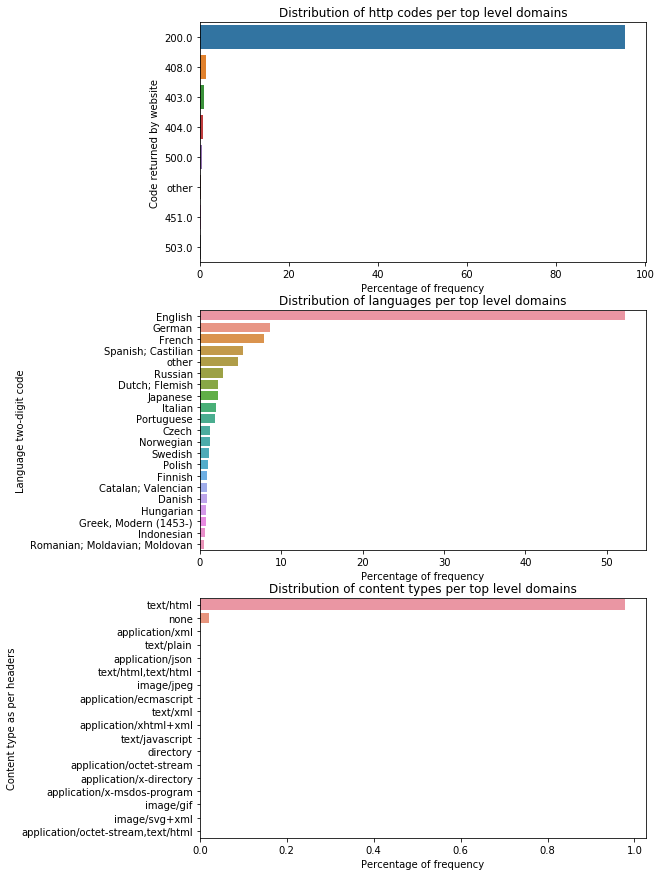

In [16]:
reference_urls_codes = netloc_url_attrs_df['code'].value_counts(dropna=False, normalize=True).reset_index()
reference_urls_codes['code'] = reference_urls_codes['code']*100
reference_urls_codes = aggregate_other(reference_urls_codes, by='index', count_name = 'code', other_thr=0.1)
fig, ax = plt.subplots(3,1,figsize=[8,15])

g = sns.barplot(y='index', x='code', data = reference_urls_codes, ax=ax[0], orient='h')
g.set_title("Distribution of http codes per top level domains")
g.set(ylabel='Code returned by website', xlabel='Percentage of frequency')

non_langs = ['error','no content-type','no body','not text/html','parsing error','connection error on reading']
reference_urls_lan = netloc_url_attrs_df[netloc_url_attrs_df['language_crawl']\
                        .apply(lambda x: x not in non_langs)]['language_crawl']\
                        .value_counts(dropna=False, normalize=True).reset_index()

reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.5)
language_codes = dict(languages_and_countries.languages)
reference_urls_lan['label'] = reference_urls_lan['index'].transform(lambda x: language_codes[x] if x != 'other' else x)

g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[1])
g.set_title("Distribution of languages per top level domains")
g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

reference_urls_type = netloc_url_attrs_df['content-type']\
    .apply(lambda x : x.replace(' ','').lower().split(';')[0] if x != '' else 'none')\
    .value_counts(dropna=False, normalize=True).reset_index()
g = sns.barplot(y='index', x='content-type', data = reference_urls_type, ax=ax[2])
g.set_title("Distribution of content types per top level domains")
g.set(ylabel='Content type as per headers', xlabel='Percentage of frequency')
plt.show()

## Checking http status and language for a sample of urls

In [10]:
#n = 500000
#print('{} out of {} is {}%'.format(n,reference_urls.shape[0], n/reference_urls.shape[0]*100))
#reference_urls_sample = reference_urls.sample(n=n, random_state=42).reset_index(drop=True)
#for i in range(40,50):
#    print('Trying chunck {}\n'.format(i))
#    mp_http_checker(l=reference_urls_sample.loc[i*10000:(i+1)*10000-1].iterrows(),fn = 'sample_url_attrs/sample_{}.json'.format(i), by='reference_url')
#    print('\n')

In [12]:
sample_url_attrs_jsons = []
for i in range(50):
    with open('data/sample_url_attrs/sample_{}.json'.format(i),'rb') as f:
        sample_url_attrs_jsons.append(json.load(f))
sample_url_attrs_json = [item for sublist in sample_url_attrs_jsons for item in sublist]
sample_url_attrs_df = pd.DataFrame(sample_url_attrs_json).fillna('')
sample_url_attrs_df['language_crawl'] = sample_url_attrs_df['language_crawl'].transform(lambda x : x[0])
sample_url_attrs_df

url error_msg code  \
0       https://www.ebi.ac.uk/europepmc/webservices/re...      none  200   
1       https://www.ebi.ac.uk/europepmc/webservices/re...      none  200   
2       https://www.ebi.ac.uk/europepmc/webservices/re...      none  200   
3              http://europepmc.org/abstract/MED/29187592      none  200   
4       https://www.ebi.ac.uk/europepmc/webservices/re...      none  200   
...                                                   ...       ...  ...   
499995  https://api.crossref.org/works/10.1103%2FPHYSR...      none  200   
499996  https://api.crossref.org/works/10.1007%2FS1101...      none  200   
499997  https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...      none  200   
499998   http://www.heritage.org.nz/the-list/details/1211      none  200   
499999                    https://viaf.org/viaf/46758457/      none  200   

                           content-type  \
0        application/json;charset=UTF-8   
1        application/json;charset=UTF-8   
2        application/json;charset=UTF-8   
3               text/html;charset=UTF-8   
4        application/json;charset=UTF-8   
...                                 ...   
499995   application/json;charset=UTF-8   
499996   application/json;charset=UTF-8   
499997  application/json; charset=UTF-8   
499998         text/html; charset=utf-8   
499999                        text/html   

                                                final_url reason  \
0       https://www.ebi.ac.uk/europepmc/webservices/re...     OK   
1       https://www.ebi.ac.uk/europepmc/webservices/re...     OK   
2       https://www.ebi.ac.uk/europepmc/webservices/re...     OK   
3               http://europepmc.org/article/MED/29187592     OK   
4       https://www.ebi.ac.uk/europepmc/webservices/re...     OK   
...                                                   ...    ...   
499995  https://api.crossref.org/works/10.1103%2FPHYSR...     OK   
499996  https://api.crossref.org/works/10.1007%2FS1101...     OK   
499997  https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...     OK   
499998  https://www.heritage.org.nz/the-list/details/1211     OK   
499999                    https://viaf.org/viaf/46758457/     OK   

       language_crawl  
0                  en  
1                  no  
2                  en  
3                  en  
4                  en  
...               ...  
499995             no  
499996             en  
499997             en  
499998             en  
499999             la  

[500000 rows x 7 columns]

/home/k2031554/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



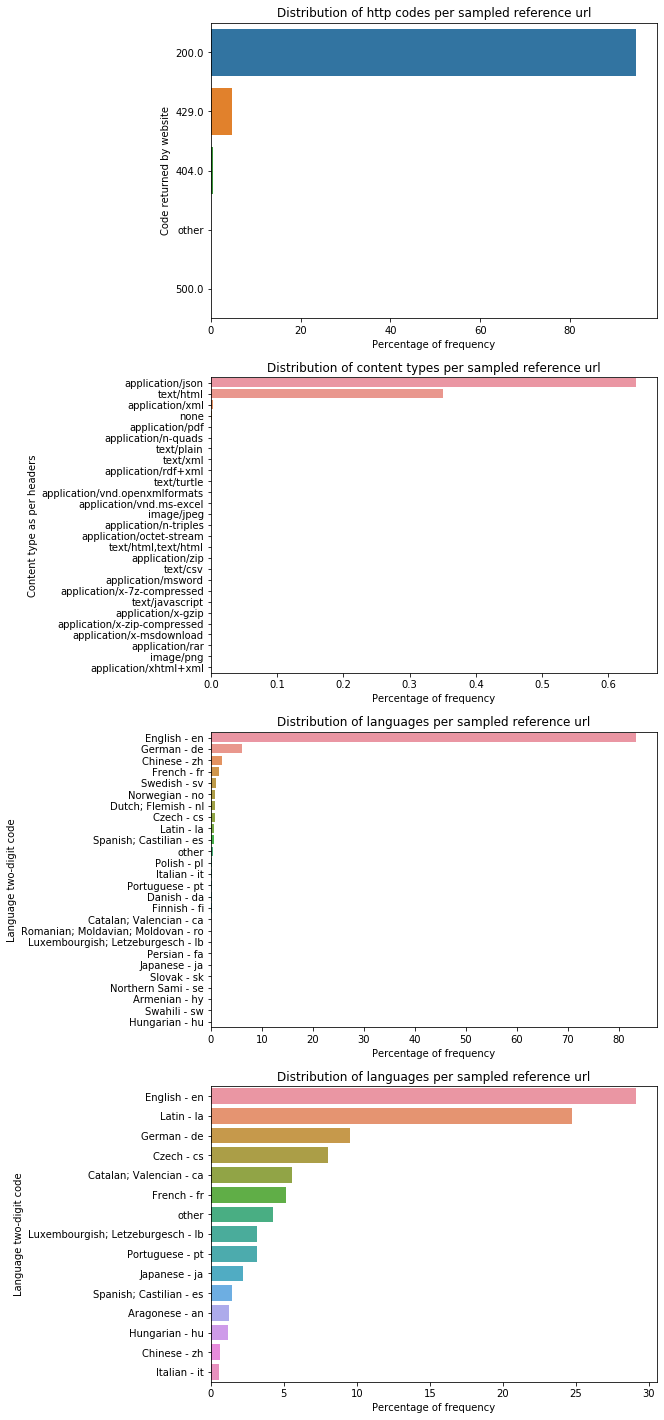

In [13]:
reference_urls_codes = sample_url_attrs_df['code'].value_counts(dropna=False, normalize=True).reset_index()
reference_urls_codes['code'] = reference_urls_codes['code']*100
reference_urls_codes = aggregate_other(reference_urls_codes, by='index', count_name = 'code', other_thr=0.1)
fig, ax = plt.subplots(4,1,figsize=[8,25])

g = sns.barplot(y='index', x='code', data = reference_urls_codes, ax=ax[0], orient='h')
g.set_title("Distribution of http codes per sampled reference url")
g.set(ylabel='Code returned by website', xlabel='Percentage of frequency')

reference_urls_type = sample_url_attrs_df['content-type']\
    .apply(lambda x : x.replace(' ','').lower().split(';')[0] if x != '' else 'none')\
    .value_counts(dropna=False, normalize=True).reset_index()
reference_urls_type['index'] = reference_urls_type['index'].apply(lambda x: x[:30])
g = sns.barplot(y='index', x='content-type', data = reference_urls_type, ax=ax[1])
g.set_title("Distribution of content types per sampled reference url")
g.set(ylabel='Content type as per headers', xlabel='Percentage of frequency')

non_langs = ['error','n', 'no content-type','no body','not text/html','parsing error','connection error on reading']

reference_urls_lan = sample_url_attrs_df[sample_url_attrs_df['language_crawl']\
                        .apply(lambda x: x not in non_langs)]['language_crawl']\
                        .value_counts(dropna=False, normalize=True).reset_index()

reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.05)
language_codes = dict(languages_and_countries.languages)
reference_urls_lan['label'] = reference_urls_lan['index'].transform(lambda x: language_codes[x]+' - '+x if x in language_codes else x)

g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[2])
g.set_title("Distribution of languages per sampled reference url")
g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

reference_urls_lan = sample_url_attrs_df[sample_url_attrs_df['content-type'] == 'text/html']
reference_urls_lan = reference_urls_lan[sample_url_attrs_df['language_crawl']\
                        .apply(lambda x: x not in non_langs)]['language_crawl']\
                        .value_counts(dropna=False, normalize=True).reset_index()

reference_urls_lan['language_crawl'] = reference_urls_lan['language_crawl']*100
reference_urls_lan = aggregate_other(reference_urls_lan, by='index', count_name = 'language_crawl', other_thr=0.5)
language_codes = dict(languages_and_countries.languages)
reference_urls_lan['label'] = reference_urls_lan['index'].transform(lambda x: language_codes[x]+' - '+x if x in language_codes else x)

g = sns.barplot(y='label', x='language_crawl', data = reference_urls_lan, ax=ax[3])
g.set_title("Distribution of languages per sampled reference url")
g.set(ylabel='Language two-digit code', xlabel='Percentage of frequency')

plt.show()

# Getting links for internal and external references

THE ORDER OF PRIORITY IN GETTING A URL IS:
     - THE FIRST EXTERNAL URL AVIALABLE
     - INTERNAL URL FROM THE FIRST URL FORMATTER IN THE EXTERNAL ID
     - WIKIBASE IMPORT URL FROM THE IMPORTED FROM WIKIBASE PROPERTY
     - OFFICIAL URL OF THE STATED-IN ENTITY
     - URL TAKEN FROM THE FORMATTER-URL OF THE FIRST EXTERNAL ID OF THE STATED-IN ENTITY  
     - INFERRED FROM WIKIDATA ITEM

In [14]:
reference_block_hashes = pd.read_csv('data/reference_block_hashes.csv',header=None)
reference_block_hashes.columns = ['reference_block_hash']
reference_block_hashes.drop(
    reference_block_hashes[reference_block_hashes['reference_block_hash'] == 'none'].index,
    inplace = True
)
#reference_block_hashes_sample = reference_block_hashes.sample(n=500, random_state=42).reset_index(drop=True)
#reference_block_hashes_sample

In [15]:
from pprint import pprint
class AutoCheckException(Exception):
    def __init__(self, *args):
        if args:
            self.message = args[0]
        else:
            self.message = None

    def __str__(self):
        #print('calling str')
        if self.message:
            return 'AutoCheckException, {0} '.format(self.message)
        else:
            return 'AutoCheckException has been raised'
        
def process_reference_node_urls(reference_block_hash):
    # GETTING ALL ATTRIBUTES OF THE NODE
    sql_cursor.execute('''
        select * from reference_nodes_values
        where reference_block_hash = '{0}'
    '''.format(reference_block_hash))
    ref_node = sql_cursor.fetchall()
    #pprint(ref_node)
    attrs = {
        'reference_block_hash': reference_block_hash,
        'url' : None,
        'url_type' : None,
        'is_inferred_from': None,
        'stated_in' : [],
        'external_id_prop' : None,
        'external_id' : None,
        'internal_urls' : None,
        'external_url' : None,
        'wikibase_import_urls' : [],
        'retrieved': None,
        'publication_date' : None,
        'ref_node': None
    }
    # PARSING THE ATTRIBUTES OF THE NODE
    for snak in ref_node:
        if snak[4] in ('external-id','string'):
            # REWORK THIS
            if snak[4] == 'external-id': #ALREADY RECORD THESE IF IT IS EXTERNAL ID TYPE
                if attrs['external_id'] is not None:
                    raise AutoCheckException('More than a single external id on ref node:\n{}'.format(ref_node))
                else:
                    attrs['external_id'] = snak[5]
                    attrs['external_id_prop'] = snak[1]
            external_id_prop = get_entity(snak[1])
            if 'P1630' in external_id_prop['claims']:
                if snak[4] == 'string': #RECORD THESE NOW IF IT IS STRING TYPE
                    if attrs['external_id'] is not None:
                        raise AutoCheckException('More than a single external id on ref node:\n{}'.format(ref_node))
                    else:
                        attrs['external_id'] = snak[5]
                        attrs['external_id_prop'] = snak[1]
                formatter_urls = [p['mainsnak']['datavalue']['value'] for p in external_id_prop['claims']['P1630']]
                attrs['internal_urls'] = [p.replace('$1', attrs['external_id']) for p in formatter_urls]                   
        elif snak[1] == 'P248' and snak[4] == 'wikibase-item':
            attrs['stated_in'].append(json.loads(snak[5].replace("'",'"'))['id'])
        elif snak[1] == 'P854' and snak[4] == 'url':            
            if attrs['external_url'] != None:
                continue
                #raise AutoCheckException('More than a single url on ref node:\n{}'.format(ref_node))
            else:
                attrs['external_url'] = snak[5]
        elif snak[1] == 'P813' and snak[4] == 'time':
            if attrs['retrieved'] != None:
                raise AutoCheckException('More than a single retrieved on ref node:\n{}'.format(ref_node))
            else:
                attrs['retrieved'] = json.loads(snak[5].replace("'",'"'))
        elif snak[1] == 'P577' and snak[4] == 'time':
            if attrs['publication_date'] is not None:
                raise AutoCheckException('More than a single publication date on ref node:\n{}'.format(ref_node))
            else:
                attrs['publication_date'] = json.loads(snak[5].replace("'",'"'))
        elif snak[1] == 'P4656' and snak[4] == 'url':
            attrs['wikibase_import_urls'].append(snak[5])
        elif snak[1] == 'P3452' and snak[4] == 'wikibase-item':
            if attrs['is_inferred_from'] is not None:
                continue
                #raise AutoCheckException('More than a single inferred from on ref node:\n{}'.format(ref_node))
            else:
                attrs['is_inferred_from'] = json.loads(snak[5].replace("'",'"'))['id']
            
    if attrs['external_url']:
        attrs['url'] = attrs['external_url']
        attrs['url_type'] = 'external_url'
    elif attrs['internal_urls']:
        attrs['url'] = attrs['internal_urls'][0]
        attrs['url_type'] = 'internal_url'
    elif len(attrs['wikibase_import_urls']) > 0:
        attrs['url'] = attrs['wikibase_import_urls'][0]
        attrs['url_type'] = 'wikibase_import_url'
    
    if attrs['url'] is None:
        if len(attrs['stated_in']) > 0:
            # REFERENCES MAY HAVE MULTIPLE STATED_IN, BUT WE ONLY USE THE FIRST ONE. MENTION THAT IN PAPER.
            stated_in_entity = get_entity(attrs['stated_in'][0])
            if 'P856' in stated_in_entity['claims']:
                attrs['url'] = stated_in_entity['claims']['P856'][0]['mainsnak']['datavalue']['value']
                attrs['url_type'] = 'stated_in_official_url'
            else:
                for claim in [claimset[0] for claimset in stated_in_entity['claims'].values() if len(claimset)==1]:
                    # STATED IN ITENS MAY HAVE MORE THAN ONE EXTERNAL ID, BUT WE ONLY TAKE THE FIRST THAT WORKA
                    if claim['mainsnak']['datatype'] == 'external-id':
                        external_id_prop_2 = get_entity(claim['mainsnak']['property'])
                        if 'P1630' in external_id_prop_2['claims']:
                            attrs['url'] = external_id_prop_2['claims']['P1630'][0]['mainsnak']['datavalue']['value'].\
                                replace(
                                    '$1',
                                    claim['mainsnak']['datavalue']['value']
                                )
                            attrs['url_type'] = 'stated_in_identifier_url'
                            break
                            
    if attrs['url'] is None and attrs['is_inferred_from'] != None:
        attrs['url'] = 'https://www.wikidata.org/wiki/' + attrs['is_inferred_from']
        attrs['url_type'] = 'inferred_from_wikidata'       
            
    
    attrs['stated_in'] = ','.join(attrs['stated_in']) if len(attrs['stated_in']) > 0 else None
    attrs['ref_node'] = ref_node
    
    return attrs    

In [52]:
#seed = random.randint(0,2**32 - 1)
#print(seed)
reference_block_hashes_sample = reference_block_hashes.sample(n=50000, random_state=42).reset_index(drop=True)

        
sql_cursor.execute(
    ''' select distinct(reference_block_hash)
    from reference_nodes_values 
    where reference_property_id = 'P248'
 '''
)
attrs_list = []
for row in reference_block_hashes_sample.iterrows():
    attrs_list.append(process_reference_node_urls(row[1]['reference_block_hash']))
    
reference_block_hashes_sample_urls = pd.DataFrame(attrs_list)
reference_block_hashes_sample_urls

KeyboardInterrupt: 

# GENERATE THE SAMPLES FOR CROWDSOURCING

In [ ]:
def get_access_attrs_or_none(url):
    if url is None:
        res = {
            'url':url,
            'error_msg':None,
            'code':None,
            'content-type':None,
            'final_url':None,
            'reason':None,
            'language_crawl':None
        }
        return res
    else:
        return get_access_attrs(url)

In [ ]:
reference_block_hashes_sample_urls_attrs = reference_block_hashes_sample_urls['url'].apply(get_access_attrs_or_none)

reference_block_hashes_sample_urls[['url_get_access_attrs','error_msg','code','content-type','final_url','reason','language_crawl']] =\
    pd.DataFrame(reference_block_hashes_sample_urls_attrs.tolist(), index=reference_block_hashes_sample_urls_attrs.index)
reference_block_hashes_sample_urls['language_crawl'] = reference_block_hashes_sample_urls['language_crawl'].apply(lambda x: x[0] if type(x) == tuple else x)
reference_block_hashes_sample_urls

In [ ]:
def convert_ref_node_text_to_pairs(ref_node_string):
    try:
        if type(ref_node_string) == list:
            ref_node = ref_node_string
        elif type(ref_node_string) == str:
            ref_node = eval(ref_node_string)
        pairs = {}
        for e in ref_node:
            prop_label = get_label(e[1])
            if e[4] == 'wikibase-item':
                prop_value_id = json.loads(e[5].replace("'",'"'))['id']
                prop_value_label = get_label(prop_value_id)
                #prop_value_url = 'http://www.wikidata.org/entity/' + prop_value_id
                pairs[prop_label] = 'wikibase-item:>' + prop_value_label + '->' + prop_value_id
            elif e[4] == 'time':
                prop_value_time = json.loads(e[5].replace("'",'"'))['time']
                pairs[prop_label] = 'time:>' + prop_value_time
            elif e[4] == 'url':
                prop_value_url = e[5]
                pairs[prop_label] = 'url:>' + prop_value_url
            else:
                prop_value_val = e[5]
                pairs[prop_label] = 'value:>' + prop_value_val

        return pairs
    except:
        traceback.print_exc()
        print(ref_node_string)
        print(type(ref_node_string))

#convert_ref_node_text_to_pairs(reference_block_hashes_sample_urls['ref_node'][1])

In [ ]:
reference_block_hashes_sample_urls['ref_node_pairs'] = reference_block_hashes_sample_urls['ref_node'].apply(convert_ref_node_text_to_pairs)

In [ ]:
reference_block_hashes_sample_urls.to_csv('Crowdsourcing/data/crowdsourcing_sample_raw_1.csv',index=False)

# Useful SPARQL Queries

SPARQL Endpoint: https://query.wikidata.org/

## Retrieve all statements where a certain reference node is used:

```
select ?s
where {
 ?s prov:wasDerivedFrom wdref:{reference_block_hash}.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
```

## Retrieve all properties of a reference node:

```
select ?p ?ppLabel ?o ?oLabel
where {
 wdref:{reference_block_hash} ?p ?o.
 ?pp wikibase:reference ?p.
 ?pp a wikibase:Property.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
```